In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from optibot.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from optibot.numpy import unpack

In [4]:
init_vprinting()

### Symbolic Problem Modelling

In [5]:
m0, m1, m2, m3, m4, l0, l1, l2, l3, l4, t, g = symbols('m_0:5 l_0:5 t g')
I0, I1, I2, I3, I4, d0, d1, d2, d3, d4 = symbols('I_0:5 d_0:5')
q0, q1, q2, q3, q4 = dynamicsymbols('q_0:5')
m0, m1, m2, m3, m4, l0, l1, l2, l3, l4, t, g, I0, I1, I2, I3, I4, d0, d1, d2, d3, d4, q0, q1, q2, q3, q4

In [6]:
N_in = ReferenceFrame('N')
P0 = Point('P0')
P0.set_vel(N_in, 0)

N0 = N_in.orientnew('N0', 'Axis', [q0, N_in.z])
P1 = P0.locatenew('P1', l0 * N0.y)
P1.set_vel(N_in, P1.pos_from(P0).dt(N_in))
CM0 = P0.locatenew('CM0', (l0-d0) * N0.y)
CM0.set_vel(N_in, CM0.pos_from(P0).dt(N_in))
I_0 = inertia(N0, 0, 0, I0)
body0 = RigidBody('Stance_Tibia', CM0, N0, m0, (I_0,CM0))
body0.potential_energy = m0 * g * CM0.pos_from(P0).dot(N_in.y)


N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P2 = P1.locatenew('P2', l1 * N1.y)
P2.set_vel(N_in, P2.pos_from(P0).dt(N_in))
CM1 = P1.locatenew('CM1', (l1-d1) * N1.y)
CM1.set_vel(N_in, CM1.pos_from(P0).dt(N_in))
I_1 = inertia(N1, 0, 0, I1)
body1 = RigidBody('Stance_Femur', CM1, N1, m1, (I_1,CM1))
body1.potential_energy = m1 * g * CM1.pos_from(P0).dot(N_in.y)


N2 = N_in.orientnew('N2', 'Axis', [q2, N_in.z])
P3 = P2.locatenew('P3', l2 * N2.y)
P3.set_vel(N_in, P3.pos_from(P0).dt(N_in))
CM2 = P2.locatenew('CM2', d2 * N2.y)
CM2.set_vel(N_in, CM2.pos_from(P0).dt(N_in))
I_2 = inertia(N2, 0, 0, I2)
body2 = RigidBody('Torso', CM2, N2, m2, (I_2,CM2))
body2.potential_energy = m2 * g * CM2.pos_from(P0).dot(N_in.y)


N3 = N_in.orientnew('N3', 'Axis', [q3, N_in.z])
P4 = P2.locatenew('P4', -l3 * N3.y)
P4.set_vel(N_in, P4.pos_from(P0).dt(N_in))
CM3 = P2.locatenew('CM3', -d3 * N3.y)
CM3.set_vel(N_in, CM3.pos_from(P0).dt(N_in))
I_3 = inertia(N3, 0, 0, I3)
body3 = RigidBody('Swing_Femur', CM3, N3, m3, (I_3,CM3))
body3.potential_energy = m3 * g * CM3.pos_from(P0).dot(N_in.y)


N4 = N_in.orientnew('N4', 'Axis', [q4, N_in.z])
P5 = P4.locatenew('P5', -l4 * N4.y)
P5.set_vel(N_in, P5.pos_from(P0).dt(N_in))
CM4 = P4.locatenew('CM4', -d4 * N4.y)
CM4.set_vel(N_in, CM4.pos_from(P0).dt(N_in))
I_4 = inertia(N4, 0, 0, I4)
body4 = RigidBody('Swing_Tibia', CM4, N4, m4, (I_4,CM4))
body4.potential_energy = m4 * g * CM4.pos_from(P0).dot(N_in.y)

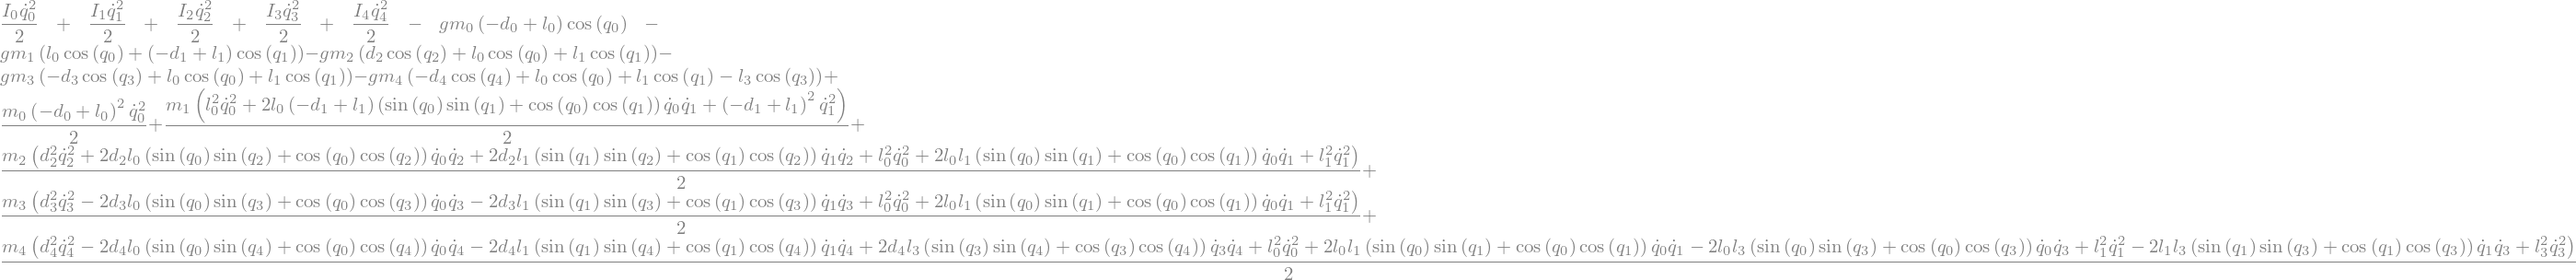

In [7]:
Lag_simp = Lagrangian(N_in, body0, body1, body2, body3, body4)
Lag_simp

In [8]:
from optibot.symbolic import ImplicitLagrangesMethod

In [9]:
u0, u1, u2, u3, u4 = symbols('u_:5')
FL = [
    (N0, (u0-u1) * N_in.z),
    (N1, (u1-u2) * N_in.z),
    (N2, (u2-u3) * N_in.z),
    (N3, (u3-u4) * N_in.z),
    (N4, u4 * N_in.z)
]
LM_small = ImplicitLagrangesMethod(Lag_simp, [q0, q1, q2, q3, q4], forcelist=FL, frame=N_in)

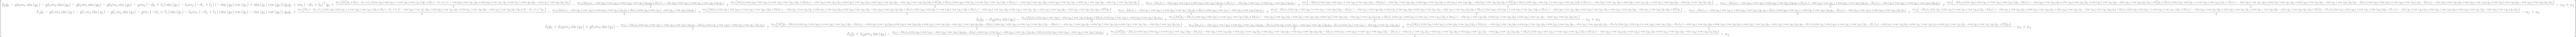

In [10]:
LM_small.form_lagranges_equations()

In [11]:
impl_x = LM_small.implicit_dynamics_x

In [12]:
from optibot.symbolic import print_funcs

In [13]:
impl_q = LM_small.implicit_dynamics_q

In [14]:
from optibot.casadi import implicit_dynamic_q_to_casadi_function, implicit_dynamic_x_to_casadi_function

In [15]:
from optibot.symbolic import find_arguments

In [16]:
find_arguments(impl_q, list(LM_small._q), separate_as=True, separate_lambdas=True, verbose=True)

x vars expected: [q_0, q_1, q_2, q_3, q_4, v_0, v_1, v_2, v_3, v_4]
x vars found: [q_0, q_1, q_2, q_3, q_4, v_0, v_1, v_2, v_3, v_4]
u vars found: [u_0, u_1, u_2, u_3, u_4]
Lambda variables are separated from parameters
lambda vars found: []
a variables are separated from parameters
a vars expected: [a_0, a_1, a_2, a_3, a_4]
a vars found: [a_0, a_1, a_2, a_3, a_4]
Parameters found: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]


In [22]:
imp_dyn_x_f_cas = implicit_dynamic_x_to_casadi_function(impl_x, list(dynamicsymbols('x_0:10')), verbose=True)

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot, x_9_dot]
x vars found: [x_0, x_0_dot, x_1, x_1_dot, x_2, x_2_dot, x_3, x_3_dot, x_4, x_4_dot, x_5, x_5_dot, x_6, x_6_dot, x_7, x_7_dot, x_8, x_8_dot, x_9, x_9_dot]
u vars found: [u_0, u_1, u_2, u_3, u_4]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot, x_9_dot]
	u: [u_0, u_1, u_2, u_3, u_4]
	lambdas: []
	params: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]



In [23]:
imp_dyn_q_f_cas = implicit_dynamic_q_to_casadi_function(impl_q, list(LM_small.q), verbose=True)

x vars expected: [q_0, q_1, q_2, q_3, q_4, v_0, v_1, v_2, v_3, v_4]
x vars found: [q_0, q_1, q_2, q_3, q_4, v_0, v_1, v_2, v_3, v_4]
u vars found: [u_0, u_1, u_2, u_3, u_4]
Lambda variables are separated from parameters
lambda vars found: []
a variables are separated from parameters
a vars expected: [a_0, a_1, a_2, a_3, a_4]
a vars found: [a_0, a_1, a_2, a_3, a_4]
Parameters found: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]
Function Arguments:
	q: [q_0, q_1, q_2, q_3, q_4]
	v: [v_0, v_1, v_2, v_3, v_4]
	a: [a_0, a_1, a_2, a_3, a_4]
	u: [u_0, u_1, u_2, u_3, u_4]
	lambda: []
	params: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]



Lag_num = Lag_simp.subs([
    [m0,3.2],
    [m1,6.8],
    [m2,20],
    [m3,6.8],
    [m4,3.2],
    [l0,0.4],
    [l1,0.4],
    [l2,0.625],
    [l3,0.4],
    [l4,0.4],
    [I0,0.93],
    [I1,1.08],
    [I2,2.22],
    [I3,1.08],
    [I4,0.93],
    [d0,1.128],
    [d1,0.163],
    [d2,0.2],
    [d3,0.163],
    [d4,0.128],
    [g, 9.81]
])
Lag_num

### Casadi optimization

In [20]:
I_0_n, I_1_n, I_2_n, I_3_n, I_4_n = 0.93, 1.08, 2.22, 1.08, 0.93
d_0_n, d_1_n, d_2_n, d_3_n, d_4_n = 1.128, 0.163, 0.2, 0.163, 0.128
g_n = 9.81
l_0_n, l_1_n, l_2_n, l_3_n, l_4_n = 0.4, 0.4, 0.625, 0.4, 0.4
m_0_n, m_1_n, m_2_n, m_3_n, m_4_n = 3.2, 6.8, 20, 6.8, 3.2
params = [
    I_0_n, I_1_n, I_2_n, I_3_n, I_4_n,
    d_0_n, d_1_n, d_2_n, d_3_n, d_4_n,
    g_n,
    l_0_n, l_1_n, l_3_n,
    m_0_n, m_1_n, m_2_n, m_3_n, m_4_n
]

In [21]:
import casadi as cas
from optibot.casadi import accelrestriction2casadi
from optibot.schemes import (euler_accel_restr, trapz_accel_restr, trapz_mod_accel_restr,
                             hs_mod_accel_restr, hs_accel_restr)

In [ ]:
opti = cas.Opti()
p_opts = {"expand":True,'ipopt.print_level':0, 'print_time':0}
s_opts = {"max_iter": 10000, 'tol': 1e-26}#, 'linear_solver' : "MA27"}
opti.solver("ipopt",p_opts,
                    s_opts)



In [13]:
def gen_ini_guess(N = 25, ini_guess = 'zero'):
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    elif ini_guess == 'funcs':
        def_t = np.linspace(0,2,N+1)
        def_q1 = (0.8*np.arctan(def_t*3))**2
        def_q2 = -np.sin(3*def_t**0.8)*def_t*2
        def_v1 = np.sin(5*def_t)/(def_t+0.2)
        def_v2 = -3*np.sin(5*def_t**0.8)*(4*def_t - 2*def_t**2)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess

def sol_value(u_arr):
    N = len(u_arr)
    return(np.sum(u_arr[:]**2)+np.sum(u_arr[1:-1]**2))/N

In [14]:
import time
def chrono_solve(opti, solve_repetitions):
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


In [15]:
def casadi_cartpole(N = 25, scheme = 'euler', ini_guess = 'zero', solve_repetitions = 1):
    opti = cas.Opti()
    p_opts = {"expand":True,'ipopt.print_level':0, 'print_time':0}
    s_opts = {"max_iter": 10000, 'tol': 1e-26}#, 'linear_solver' : "MA27"}
    opti.solver("ipopt",p_opts,
                        s_opts)
    restr_schemes = {
        'euler': euler_restr,
        'trapz': trapz_restr,
        'trapz_mod' : trapz_mod_restr,
        'hs': hs_restr,
        'hs_mod': hs_mod_restr,
        'hs_parab': hs_parab_restr,
        'hs_mod_parab': hs_mod_parab_restr
    }
    
    f_restr = restr_schemes[scheme]
    if scheme in ['hs_parab', 'hs_mod_parab']:
        parab = True
    else:
        parab = False
    X = opti.variable(N+1,4)
    U = opti.variable(N+1,1)
    if parab:
        U_c = opti.variable(N,1)
    T = opti.parameter()
    u_m = opti.parameter(1)
    Params = opti.parameter(4)

    cost = (cas.sum1(U[:,0]**2)+cas.sum1(U[1:-1,0]**2))/N
    if parab:
        cost = (4*cas.sum1(U_c[:,0]**2) + cas.sum1(U[:,0]**2)+cas.sum1(U[1:-1,0]**2))/(3*N)
    #cost = cas.sum1(cas.cos(X[:,1]))
    #cost = T
    opti.minimize(cost)

    opti.subject_to(X[0,:].T == [0, 0, 0, 0])
    opti.subject_to(X[-1,:].T == [1, np.pi, 0, 0])
    if parab: 
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4, 1)
    else:
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4)

    for ii in range(N):
        if parab:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1],T/N, Params, U_c[ii])==0)
            opti.subject_to(opti.bounded(-u_m, U_c[ii] ,u_m))
        else:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1,:],T/N, Params)==0)
        opti.subject_to(opti.bounded(-u_m,U[ii],u_m))

    opti.subject_to(opti.bounded(-u_m,U[-1, 0],u_m))
    opti.set_value(T, 2)
    max_f = 20.0
    opti.set_value(u_m, max_f)

    m0_n, m1_n = [1., 0.3]
    l_n = 0.5
    g_n = 9.81
    opti.set_value(Params, [g_n, l_n, m0_n, m1_n])
    
    opti.set_initial(X, gen_ini_guess(N, ini_guess))
    sol, cpudt = chrono_solve(opti, solve_repetitions)
    xx_simp = sol.value(X)
    uu_simp = sol.value(U)
    if parab:
        uu_c = sol.value(U_c)
    else:
        uu_c = None
    return xx_simp, uu_simp, uu_c, cpudt

In [16]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['lin', 'funcs']
solve_repetitions = 3
N_arr = [10,15,20,25,30,40,50,75,100,150]

results = {}

for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt = casadi_cartpole(N, scheme, init, solve_repetitions)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt
            }


#xx_hs_lin, uu_hs_lin, _, cpudt_hs_lin = casadi_cartpole(25, 'hs', ini_guess = 'lin', solve_repetitions = 10)
#xx_hs_fun, uu_hs_fun, _, cpudt_hs_fun = casadi_cartpole(25, 'hs', ini_guess = 'funcs', solve_repetitions = 10)
#xx_mod_lin, uu_mod_lin, _, cpudt_mod_lin = casadi_cartpole(25, 'hs_mod', ini_guess = 'lin', solve_repetitions = 10)
#xx_mod_fun, uu_mod_fun, _, cpudt_mod_fun = casadi_cartpole(25, 'hs_mod', ini_guess = 'funcs', solve_repetitions = 10)

#xx_hs_par_lin, uu_hs_par_lin, uu_c_hs_par_lin, cpudt_hs_par_lin = casadi_cartpole(25, 'hs_parab', ini_guess = 'lin', solve_repetitions = 10)
#xx_hs_par_fun, uu_hs_par_fun, uu_c_hs_par_fun, cpudt_hs_par_fun = casadi_cartpole(25, 'hs_parab', ini_guess = 'funcs', solve_repetitions = 10)
#xx_mod_par_lin, uu_mod_par_lin, uu_c_mod_par_lin, cpudt_mod_par_lin = casadi_cartpole(25, 'hs_mod_parab', ini_guess = 'lin', solve_repetitions = 10)
#xx_mod_par_fun, uu_mod_par_fun, uu_c_mod_par_fun, cpudt_mod_par_fun = casadi_cartpole(25, 'hs_mod_parab', ini_guess = 'funcs', solve_repetitions = 10)

Problem: hs_lin
	N = 10

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_funcs
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_lin
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_funcs
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_lin
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_funcs
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150

In [85]:
def parab_cost(U, U_c, N = 25):
    cost = (4*np.sum(U_c[:,]**2) + np.sum(U[:,]**2)+np.sum(U[1:-1,]**2))/(3*N)
    return cost

In [86]:
parab_cost(results['hs_parab_funcs'][25]['u'],results['hs_parab_funcs'][25]['u_c'])

In [87]:
parab_cost(results['hs_parab_lin'][25]['u'],results['hs_parab_lin'][25]['u_c'])

In [19]:
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print(key, results[key][25]['cpudt'])

hs_lin 0.02666441599527995
hs_funcs 0.030844688415527344
hs_mod_lin 0.02659432093302409
hs_mod_funcs 0.039275566736857094
hs_parab_lin 0.030243317286173504
hs_parab_funcs 0.032683610916137695
hs_mod_parab_lin 0.03369466463724772
hs_mod_parab_funcs 0.043061017990112305


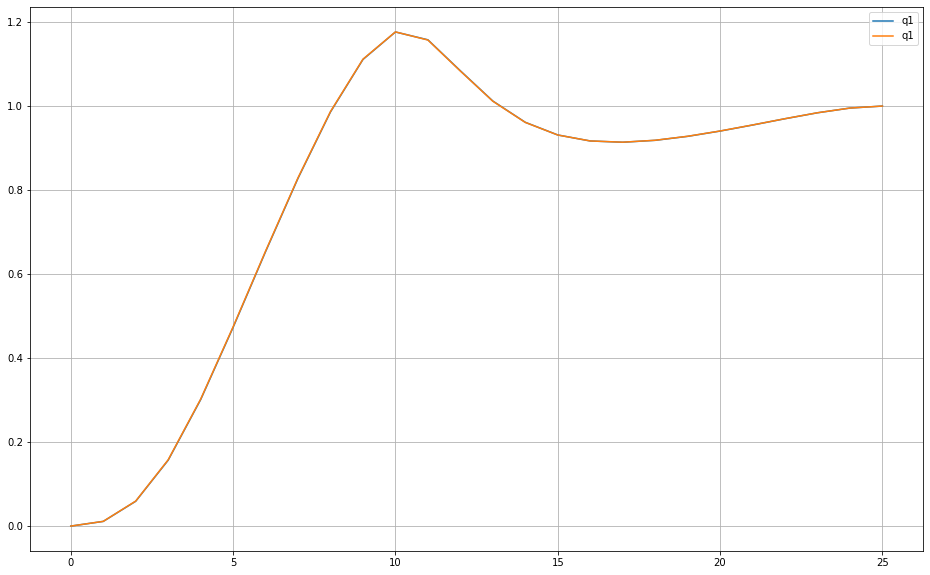

In [20]:
plt.figure(figsize=[16,10])
labels = ['q1','q2','v1','v2']
#for ii in range(4):
ii = 0
key = 'hs_parab_lin'
plt.plot(results[key][25]['x'][:,ii], label = labels[ii])
key = 'hs_mod_parab_lin'
plt.plot(results[key][25]['x'][:,ii], label = labels[ii])
plt.grid()
plt.legend()

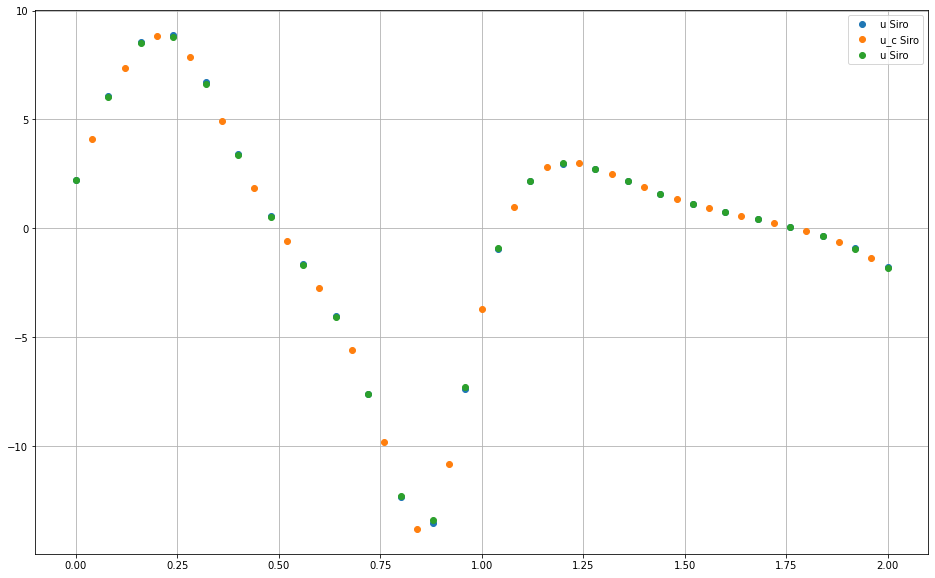

In [21]:
plt.figure(figsize=[16,10])
key = 'hs_parab_lin'
plt.plot(np.linspace(0,2,26),results[key][25]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,2,51)[1::2],results[key][25]['u_c'][:], 'o',label = 'u_c Siro')

key = 'hs_mod_parab_lin'
plt.plot(np.linspace(0,2,26),results[key][25]['u'][:], 'o',label = 'u Siro')
plt.grid()
plt.legend()

In [22]:
from optibot.schemes import integrate_hs, integrate_trapz, integrate_euler, integrate_rk4, integrate_hs_mod

In [23]:
from optibot.numpy import RHS2numpy

In [24]:
F_nump = RHS2numpy(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [25]:
F_nump([0,0,0,0],[0.5,], params)

array([ 0. ,  0. ,  0.5, -1. ])

In [26]:
from optibot.schemes import interpolated_array, interpolated_array_derivative, dynamic_error

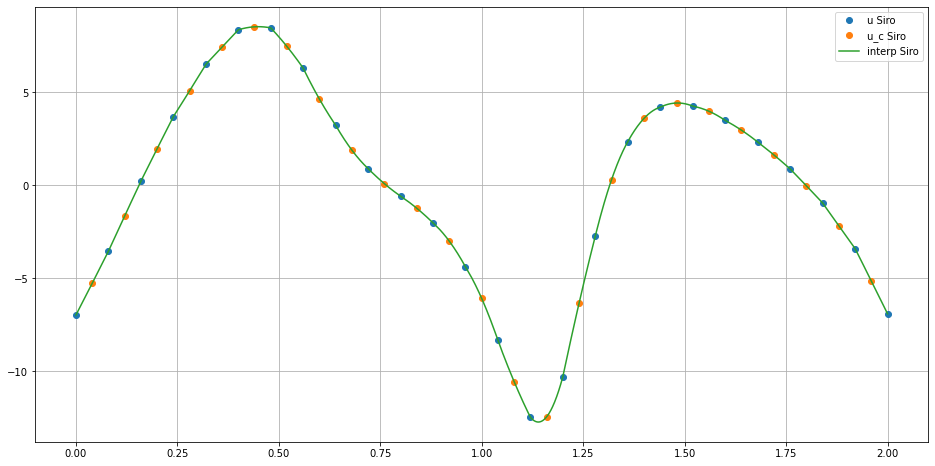

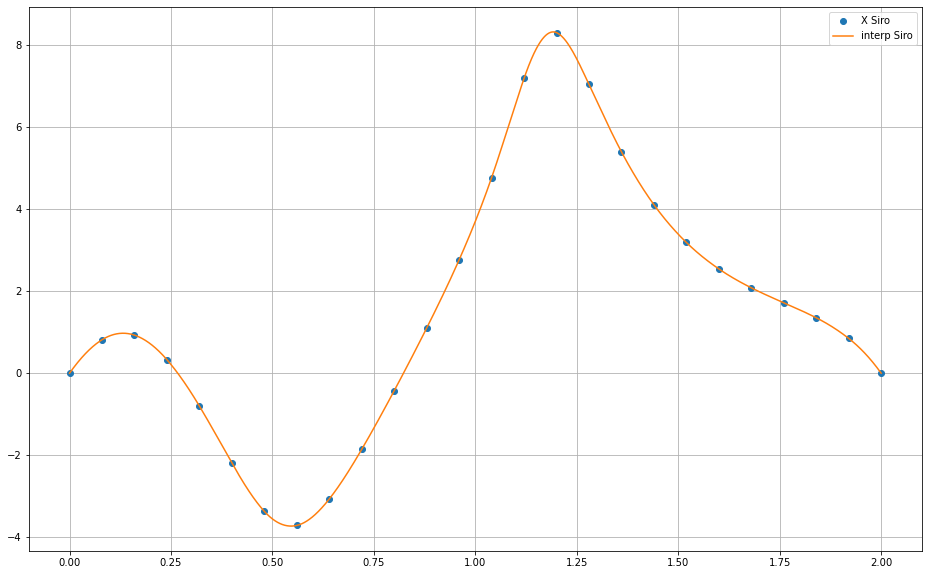

In [84]:
key = 'hs_parab_funcs'
N_prob = 25
xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F_nump,
    2/N_prob,
    np.linspace(0, 2, 2000),
    params,
    "hs_parab",
    'parab',
    [results[key][N_prob]['u_c'],]
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,2,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,2,2000),uu_hs_parab_lin_int, label = 'interp Siro')
plt.grid()
plt.legend()
ii = 3
plt.figure(figsize=[16,10])
plt.plot(np.linspace(0,2,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X Siro')
plt.plot(np.linspace(0,2,2000),xx_hs_parab_lin_int[:,ii], label = 'interp Siro')
plt.grid()
plt.legend()

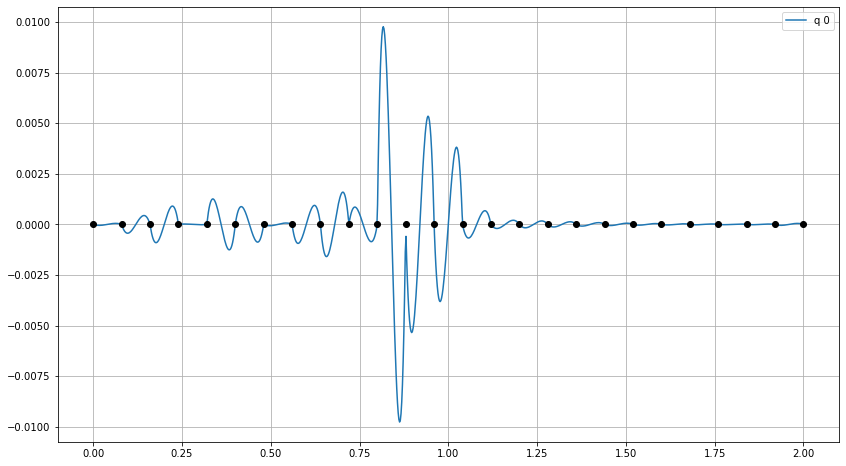

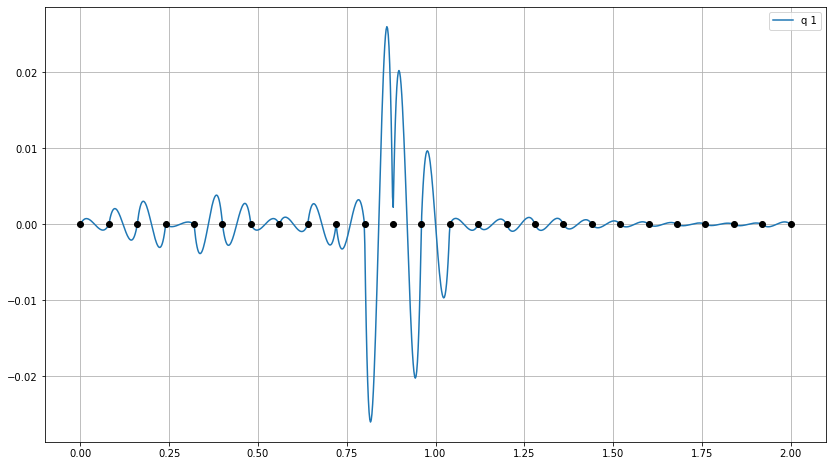

In [28]:
n_graph = 1000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_parab_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, F_nump, params,
    scheme = 'hs_parab', scheme_params=[results[key][25]['u_c'],],
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,-dyn_err_q_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,-dyn_err_q_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

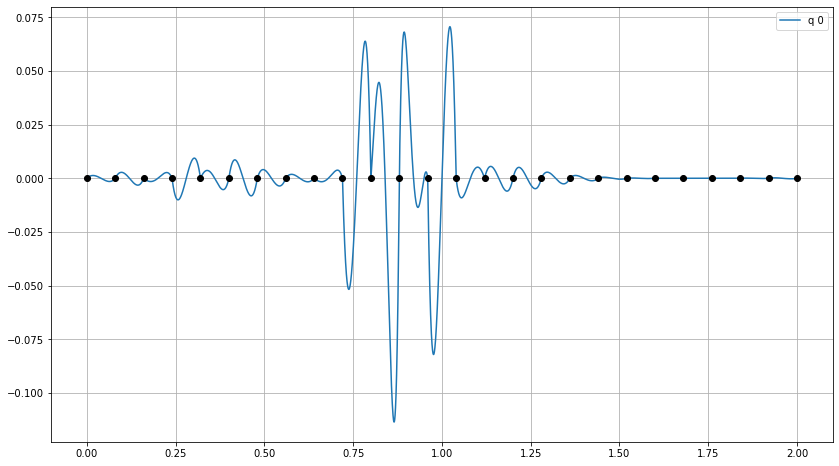

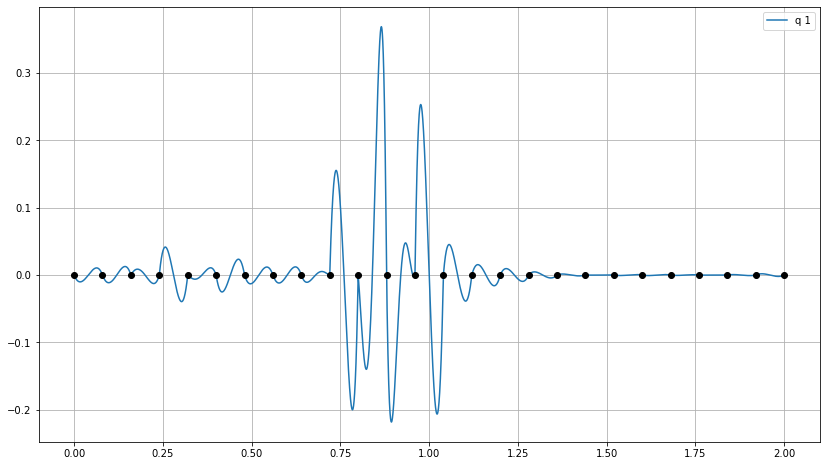

In [60]:
n_graph = 10000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_parab_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, F_nump, params,
    scheme = 'hs_parab', u_scheme='parab', scheme_params=[results[key][25]['u_c'],],
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

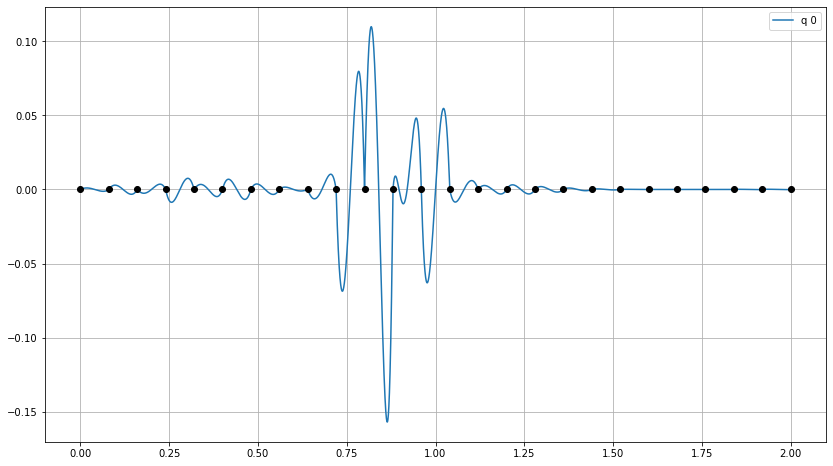

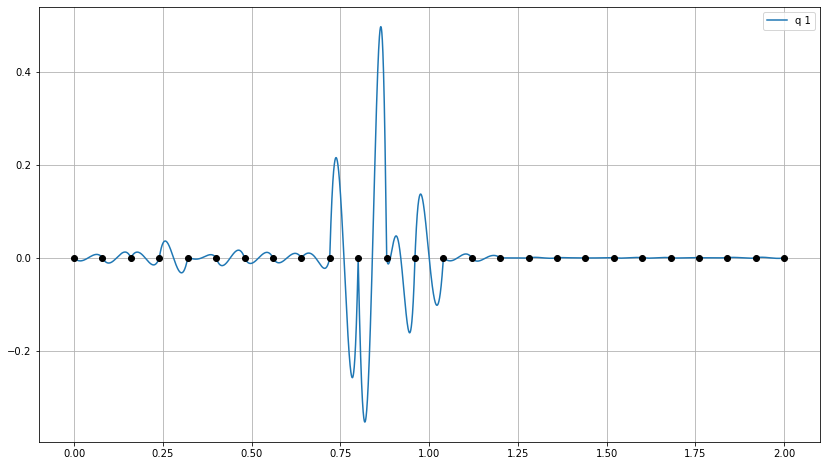

In [45]:
n_graph = 10000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, F_nump, params,
    scheme = 'hs', scheme_params=[results[key][25]['u_c'],],
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

In [31]:
def state_error(t_arr, dyn_err, N,):
    n_int = len(t_arr)
    interv_n = (N * t_arr)//2
    err = []
    cut_p = 0
    for ii in range(1,N+1):
        jj = np.searchsorted(interv_n, ii)
        err_point = np.trapz(np.abs(dyn_err[cut_p:jj+1]), t_arr[cut_p:jj+1], axis=0)
        err.append(err_point)
        cut_p = jj
    err = np.array(err, dtype = float)
    return err

def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

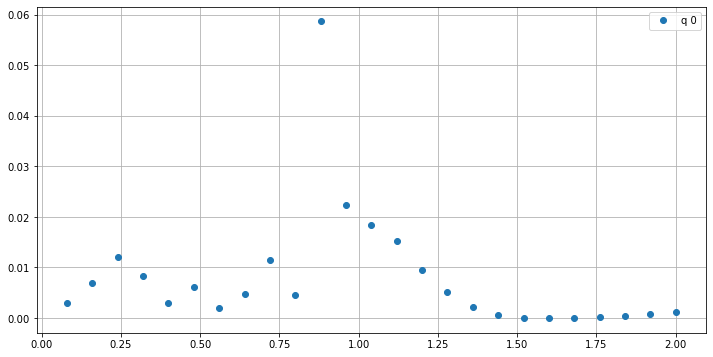

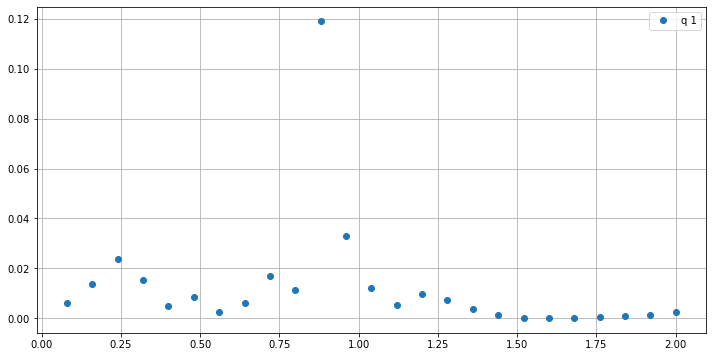

In [32]:
st_err = state_error(t_arr, dyn_err_2_b_hs_lin, 25)
plt.figure(figsize=[12,6])
ii = 0
plt.plot(np.linspace(0,2,26)[1:],st_err[:,ii], 'o', label = f'q {ii}')
plt.legend()
plt.grid()
plt.figure(figsize=[12,6])
ii = 1
plt.plot(np.linspace(0,2,26)[1:],st_err[:,ii], 'o', label = f'q {ii}')
plt.legend()
plt.grid()

In [61]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['lin', 'funcs']
n_interp = 500
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        for N in N_arr:
            print(f'\tN = {N}')
            if 'parab' in scheme:
                u_scheme = 'parab'
            else:
                u_scheme = 'lin'
            dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
                results[key][N]['x'],
                results[key][N]['u'],
                2,
                F_nump,
                params,
                scheme = scheme,
                u_scheme= u_scheme,
                scheme_params=[results[key][N]['u_c'],],
                n_interp = n_interp)
            t_arr = np.linspace(0,2, n_interp)
            tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
            tot_dyn_err_v = total_state_error(t_arr, dyn_err_v)
            tot_dyn_err_2_a = total_state_error(t_arr, dyn_err_2_a)
            tot_dyn_err_2_b = total_state_error(t_arr, dyn_err_2_b)
            results[key][N]['err_q_int'] = dyn_err_q
            results[key][N]['err_v_int'] = dyn_err_v
            results[key][N]['err_2_a_int'] = dyn_err_2_a
            results[key][N]['err_2_b_int'] = dyn_err_2_b
            results[key][N]['err_q'] = tot_dyn_err_q
            results[key][N]['err_v'] = tot_dyn_err_v
            results[key][N]['err_2_a'] = tot_dyn_err_2_a
            results[key][N]['err_2_b'] = tot_dyn_err_2_b

Problem: hs_lin
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_funcs
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_lin
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_funcs
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_lin
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_funcs
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_parab_lin
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_parab_funcs
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150


In [62]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['lin', 'funcs']
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        err_q_acum = []
        err_v_acum = []
        err_2_a_acum = []
        err_2_b_acum = []
        cpudt = []
        for N in N_arr:
            err_q_acum.append(results[key][N]['err_q'])
            err_v_acum.append(results[key][N]['err_v'])
            err_2_a_acum.append(results[key][N]['err_2_a'])
            err_2_b_acum.append(results[key][N]['err_2_b'])
            cpudt.append(results[key][N]['cpudt'])
        results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
        results[key]['err_v_acum'] = np.array(err_v_acum, dtype = float)
        results[key]['err_2_a_acum'] = np.array(err_2_a_acum, dtype = float)
        results[key]['err_2_b_acum'] = np.array(err_2_b_acum, dtype = float)
        results[key]['cpudt'] = np.array(cpudt, dtype = float)

Problem: hs_lin
Problem: hs_funcs
Problem: hs_mod_lin
Problem: hs_mod_funcs
Problem: hs_parab_lin
Problem: hs_parab_funcs
Problem: hs_mod_parab_lin
Problem: hs_mod_parab_funcs


In [63]:
results[key]['cpudt']

array([0.01728702, 0.02326735, 0.06256032, 0.04306102, 0.03938341,
       0.04093401, 0.04651705, 0.07171639, 0.13932371, 0.22491074])

In [64]:
results['hs_parab_lin'][25]['err_2_b']

array([0.11315657, 0.33943849])

In [65]:
results['hs_mod_parab_lin'][25]['err_2_b']

array([0.01625609, 0.05263655])

In [66]:
results['hs_lin'][25]['err_2_b']

array([0.08536741, 0.27599106])

In [67]:
results['hs_mod_lin'][25]['err_2_b']

array([0.01831312, 0.0536846 ])

Problem: hs_lin
Problem: hs_mod_lin
Problem: hs_parab_lin
Problem: hs_mod_parab_lin


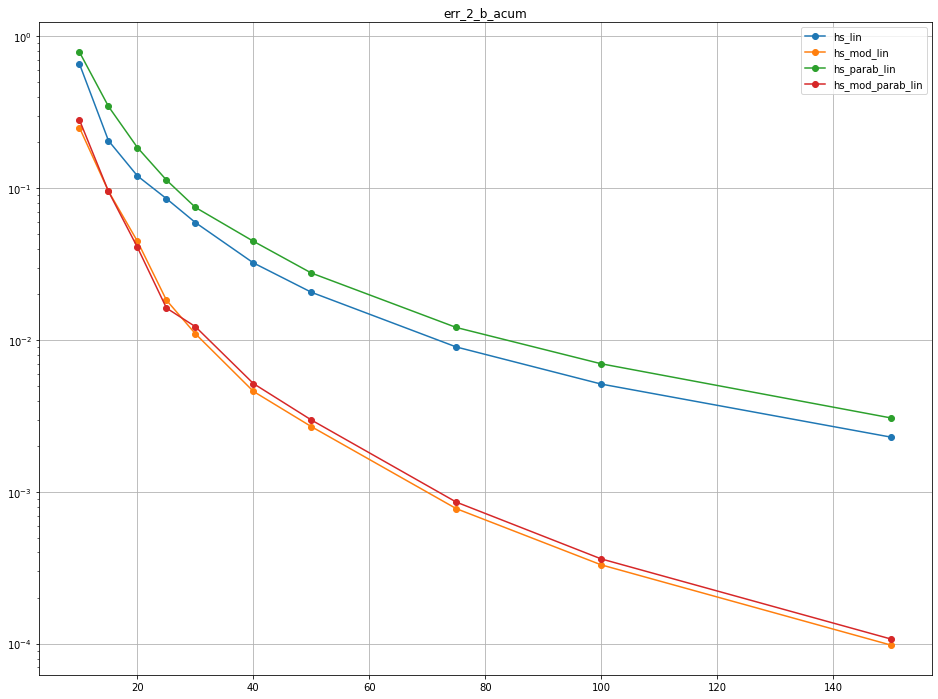

In [88]:
schemes_graph = ['hs', 'hs_mod','hs_parab', 'hs_mod_parab']
data_array = ['err_q_acum','err_v_acum','err_2_b_acum','cpudt']
initial = 'lin'
plt.figure(figsize=[16,12])


data_key = data_array[2]
qq = 0
plt.title(data_key)
for scheme in schemes_graph:
    key = scheme + '_' + initial
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    if len(results[key][data_key].shape) == 1:
        plt.plot(N_arr,results[key][data_key], marker = 'o',label = key)
    else:
        plt.plot(N_arr,results[key][data_key][:,qq], marker = 'o',label = key)
plt.yscale('log')
plt.grid()
plt.legend()

### Other checks

In [89]:
from optibot.schemes import hs_opti_step, hs_mod_opti_step, hs_parab_opti_step, hs_mod_parab_opti_step

In [92]:
n = 1
F_nump(
    results['hs_parab_lin'][25]['x'][n,:],
    results['hs_parab_lin'][25]['u'][n],
    params
)

array([  0.32853642,  -0.64648014,   5.98900473, -11.54226645])

In [91]:
F_nump(
    results['hs_parab_lin'][25]['x'][n,:],
    results['hs_parab_lin'][25]['u'][n],
    params
)- np.array([0.328536435248556, -0.646480161416857, 5.98899879213531,  -11.5422545622471])

array([-1.11408852e-08,  2.20659381e-08,  5.93531689e-06, -1.18856346e-05])

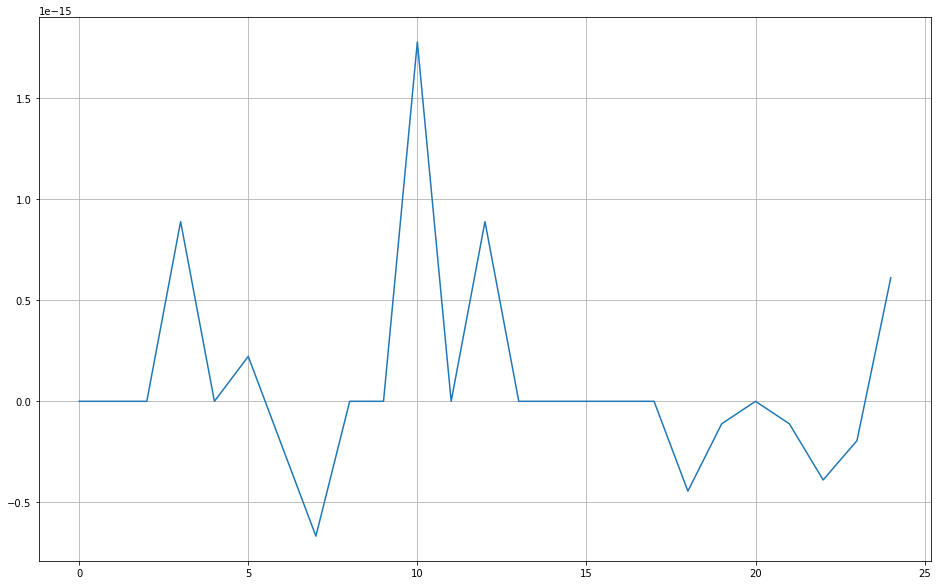

In [59]:
eq_err_Siro_notop = []
kk  = 3
for ii in range(25):
    eq_err_Siro_notop.append(
        list(hs_parab_opti_step(
            results['hs_parab_lin'][25]['x'][ii+1,:],
            results['hs_parab_lin'][25]['x'][ii,:],
            results['hs_parab_lin'][25]['u'][ii],
            results['hs_parab_lin'][25]['u'][ii+1],
            F_nump, 2/25, params,
            results['hs_parab_lin'][25]['u_c'][ii]))
    )
eq_err_Siro_notop = np.array(eq_err_Siro_notop)
plt.figure(figsize=[16,10])
plt.plot(eq_err_Siro_notop[:,kk], label = 'eq_err_Siro_notop')
plt.grid()

In [94]:
def x_central(x, x_n, h, f, f_n):
        return (x + x_n)/2 + h/8*(f-f_n)